Store with maximum sales: Store 20.0 with $301,397,792.46 in sales
Store with maximum standard deviation: Store 14.0 with std dev $317,569.95
Coefficient of variation for this store: 0.1571

Top 5 stores with highest quarterly growth rate in Q3'2012:
 Store    Q2_Sales    Q3_Sales  Growth_Rate
     7  7290859.27  8262787.39    13.330776
    16  6564335.98  7121541.64     8.488378
    35 10838313.00 11322421.12     4.466637
    26 13155335.57 13675691.91     3.955478
    39 20214128.46 20715116.23     2.478404

Mean sales during non-holiday weeks: $1,041,256.38

Average sales by holiday:
     Holiday  Weekly_Sales
Thanksgiving  1.471273e+06
  Super Bowl  1.079128e+06
  Labour Day  1.042427e+06
 Non-Holiday  1.041256e+06
   Christmas  9.608331e+05

Holidays with higher sales than non-holiday mean:
     Holiday  Weekly_Sales
Thanksgiving  1.471273e+06
  Super Bowl  1.079128e+06
  Labour Day  1.042427e+06

Monthly sales overview:
YearMonth  Weekly_Sales
  2012-01  168894471.66
  2012-02  1

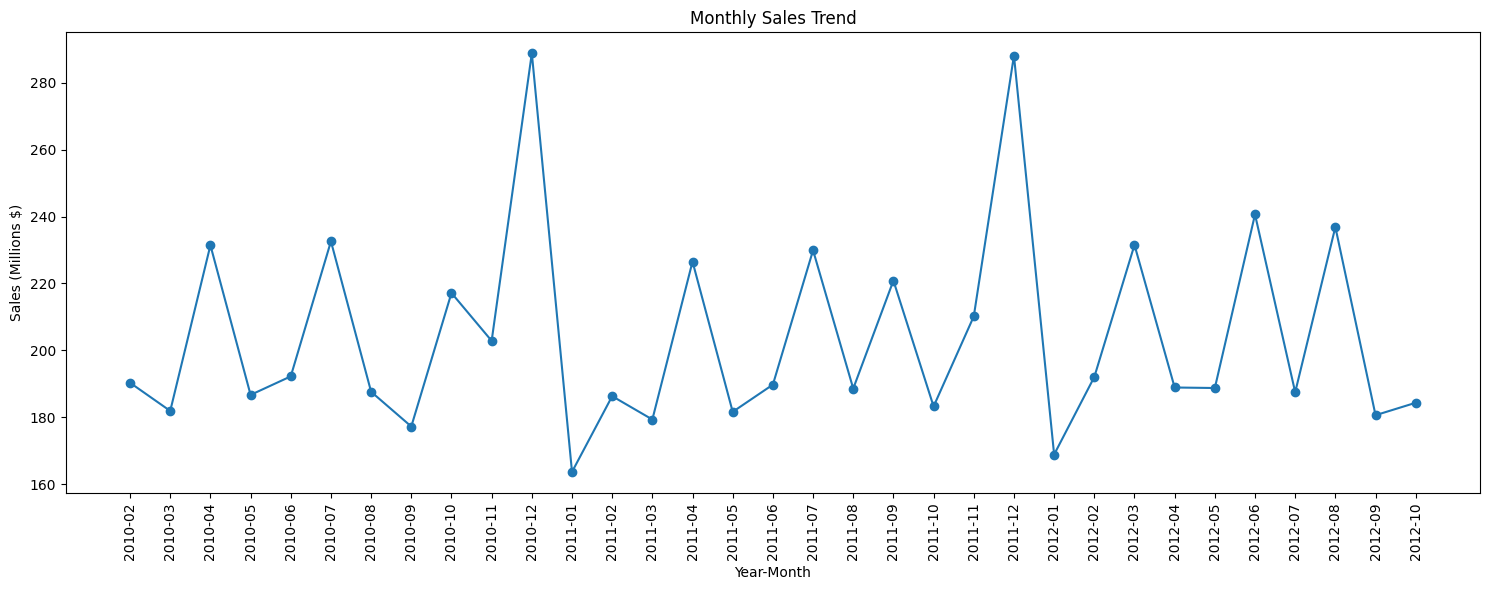

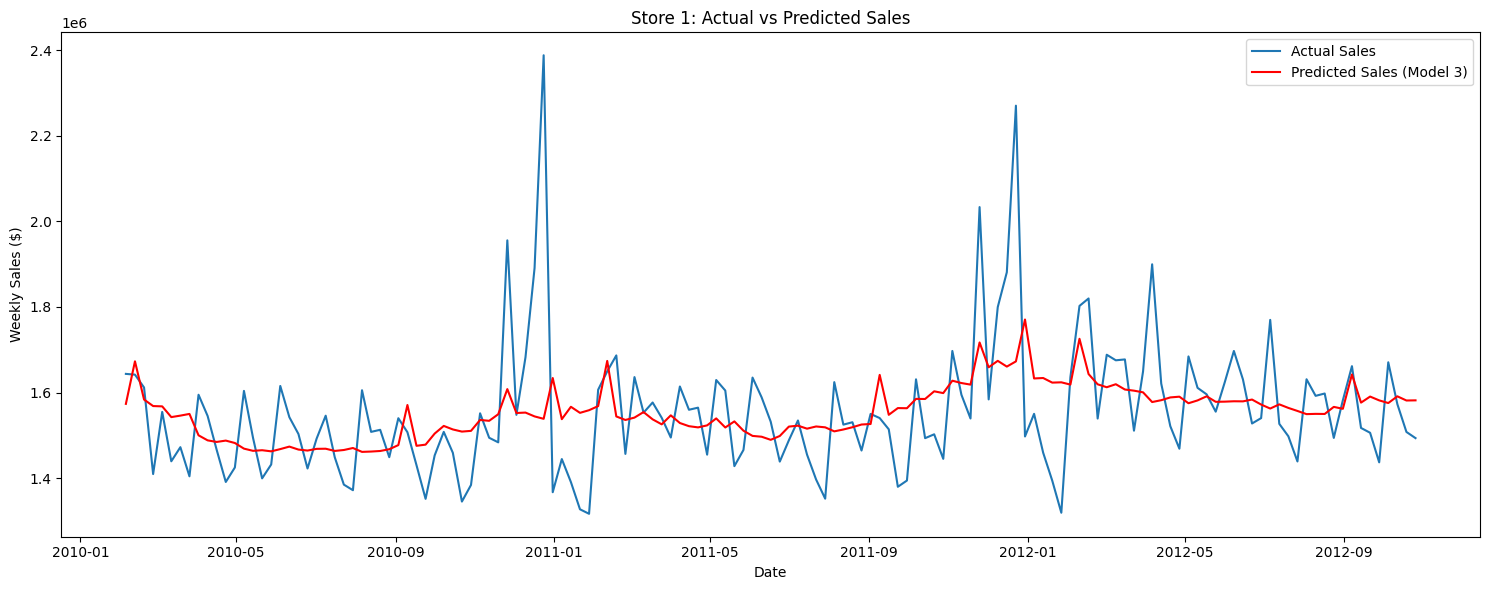

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('Walmart_Store_sales.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Add some date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Semester'] = ((df['Month'] - 1) // 6) + 1

# Define holiday dates for analysis
holidays = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
    'Labour Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
}

# Convert holiday dates to datetime
for holiday in holidays:
    holidays[holiday] = [pd.to_datetime(date) for date in holidays[holiday]]

# Identify the store with maximum sales
store_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index()
max_sales_store = store_sales.loc[store_sales['Weekly_Sales'].idxmax()]
print(f"Store with maximum sales: Store {max_sales_store['Store']} with ${max_sales_store['Weekly_Sales']:,.2f} in sales")

# Find store with maximum standard deviation
store_stats = df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std']).reset_index()
store_stats['cv'] = store_stats['std'] / store_stats['mean']  # Coefficient of variation
max_std_store = store_stats.loc[store_stats['std'].idxmax()]
print(f"Store with maximum standard deviation: Store {max_std_store['Store']} with std dev ${max_std_store['std']:,.2f}")
print(f"Coefficient of variation for this store: {max_std_store['cv']:.4f}")

# Quarterly growth rate in Q3'2012
# Filter for Q2 and Q3 2012 data
q2_2012 = df[(df['Year'] == 2012) & (df['Quarter'] == 2)]
q3_2012 = df[(df['Year'] == 2012) & (df['Quarter'] == 3)]

# Calculate quarterly sales for each store
q2_sales = q2_2012.groupby('Store')['Weekly_Sales'].sum().reset_index()
q2_sales.rename(columns={'Weekly_Sales': 'Q2_Sales'}, inplace=True)
q3_sales = q3_2012.groupby('Store')['Weekly_Sales'].sum().reset_index()
q3_sales.rename(columns={'Weekly_Sales': 'Q3_Sales'}, inplace=True)

# Combine the data and calculate growth rate
quarterly_growth = pd.merge(q2_sales, q3_sales, on='Store')
quarterly_growth['Growth_Rate'] = (quarterly_growth['Q3_Sales'] - quarterly_growth['Q2_Sales']) / quarterly_growth['Q2_Sales'] * 100

# Sort by growth rate in descending order
quarterly_growth = quarterly_growth.sort_values('Growth_Rate', ascending=False)
print("\nTop 5 stores with highest quarterly growth rate in Q3'2012:")
print(quarterly_growth.head().to_string(index=False))

# Identify holidays with higher sales than non-holiday mean
# Calculate mean sales for non-holiday weeks
non_holiday_mean = df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean()
print(f"\nMean sales during non-holiday weeks: ${non_holiday_mean:,.2f}")

# Create a function to identify which holiday a date corresponds to
def identify_holiday(date):
    for holiday, dates in holidays.items():
        if any(abs((date - holiday_date).days) <= 3 for holiday_date in dates):
            return holiday
    return None

# Add a Holiday column
df['Holiday'] = df['Date'].apply(identify_holiday)

# Replace NaN with 'Non-Holiday'
df['Holiday'] = df['Holiday'].fillna('Non-Holiday')

# Calculate average sales by holiday
holiday_sales = df.groupby('Holiday')['Weekly_Sales'].mean().reset_index()
holiday_sales = holiday_sales.sort_values('Weekly_Sales', ascending=False)
print("\nAverage sales by holiday:")
print(holiday_sales.to_string(index=False))

print("\nHolidays with higher sales than non-holiday mean:")
high_impact_holidays = holiday_sales[holiday_sales['Weekly_Sales'] > non_holiday_mean]
print(high_impact_holidays[high_impact_holidays['Holiday'] != 'Non-Holiday'].to_string(index=False))

# Monthly and semester view of sales
# Monthly analysis
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)
print("\nMonthly sales overview:")
print(monthly_sales[['YearMonth', 'Weekly_Sales']].tail(10).to_string(index=False))

# Semester analysis
semester_sales = df.groupby(['Year', 'Semester'])['Weekly_Sales'].sum().reset_index()
semester_sales['YearSemester'] = semester_sales['Year'].astype(str) + '-S' + semester_sales['Semester'].astype(str)
print("\nSemester sales overview:")
print(semester_sales.to_string(index=False))

# Visualization for monthly sales
plt.figure(figsize=(15, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Weekly_Sales'] / 1e6, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Sales (Millions $)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('monthly_sales_trend.png')

# Statistical Model for Store 1
store1_df = df[df['Store'] == 1].copy()

# Add date numeric features
min_date = store1_df['Date'].min()
store1_df['Date_Numeric'] = (store1_df['Date'] - min_date).dt.days
store1_df['Days_Since_2010'] = (store1_df['Date'] - pd.to_datetime('2010-01-01')).dt.days

# Model 1: Linear Regression with Date_Numeric
X1 = store1_df[['Date_Numeric']]
y = store1_df['Weekly_Sales']

model1 = LinearRegression()
model1.fit(X1, y)
y_pred1 = model1.predict(X1)
rmse1 = np.sqrt(mean_squared_error(y, y_pred1))
r2_1 = r2_score(y, y_pred1)

print("\nModel 1 - Linear Regression with Date_Numeric:")
print(f"RMSE: ${rmse1:,.2f}")
print(f"R² Score: {r2_1:.4f}")

# Model 2: Multiple Linear Regression with CPI, Unemployment, and Fuel_Price
X2 = store1_df[['Date_Numeric', 'CPI', 'Unemployment', 'Fuel_Price']]
model2 = LinearRegression()
model2.fit(X2, y)
y_pred2 = model2.predict(X2)
rmse2 = np.sqrt(mean_squared_error(y, y_pred2))
r2_2 = r2_score(y, y_pred2)

print("\nModel 2 - Multiple Linear Regression with economic indicators:")
print(f"RMSE: ${rmse2:,.2f}")
print(f"R² Score: {r2_2:.4f}")

# Model 3: Multiple Linear Regression with all available features
X3 = store1_df[['Date_Numeric', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Holiday_Flag']]
model3 = LinearRegression()
model3.fit(X3, y)
y_pred3 = model3.predict(X3)
rmse3 = np.sqrt(mean_squared_error(y, y_pred3))
r2_3 = r2_score(y, y_pred3)

print("\nModel 3 - Multiple Linear Regression with all features:")
print(f"RMSE: ${rmse3:,.2f}")
print(f"R² Score: {r2_3:.4f}")

# Determine best model
models = {
    'Model 1': (rmse1, r2_1),
    'Model 2': (rmse2, r2_2),
    'Model 3': (rmse3, r2_3)
}

best_model = min(models.items(), key=lambda x: x[1][0])
print(f"\nBest model based on RMSE: {best_model[0]} with RMSE ${best_model[1][0]:,.2f} and R² {best_model[1][1]:.4f}")

# Feature importance for best model (Model 3)
feature_importance = pd.DataFrame({
    'Feature': X3.columns,
    'Coefficient': model3.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print("\nFeature importance for Model 3:")
print(feature_importance.to_string(index=False))

# Plot predictions vs actual for best model
plt.figure(figsize=(15, 6))
plt.plot(store1_df['Date'], y, label='Actual Sales')
plt.plot(store1_df['Date'], y_pred3, label='Predicted Sales (Model 3)', color='red')
plt.title('Store 1: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.tight_layout()
plt.savefig('store1_predictions.png')